# Flexible Representation of Quantum Images (FRQI)

The goal of the Flexible Representation of Quantum Images (FRQI) [1] is to provide a quantum representation of images that allows an efficient encoding of the classical data into a quantum state and the subsequent use of operators for image processing operations.
In this case, encoding the classical image into a quantum state requires a polynomial number of simple gates [2].

## 1. The FRQI State

The quantum state representing the image is:

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\ket{I(\theta)}=\frac{1}{2^{n}}\sum_{i=0}^{2^{2n}-1}\left(\cos \theta_{i}\ket{0}+\sin\theta_{i}\ket{1}\right)\otimes\ket{i}
\label{eq:FRQI_state} \tag{1.1}
$$

$$
 \theta_{i}\in\left[ 0,\frac{\pi}{2}\right], i = 0,1,\cdots,2^{2n}-1
 \label{eq:FRQI_angle} \tag{1.2}
$$

The FRQI state is a normalized state as from equation $\eqref{eq:FRQI_state}$ we see that $\left\|I(\theta)\right\|=1$
and is made of two parts:

* color information encoding: $\cos\theta_{i}\ket{0}+\sin\theta_{i}\ket{1}$ 
* associated pixel position encoding: $\ket{i}$


A simple example for a $2x2$ image is given below, with corresponding $\theta$ angles (color encoding) and associated kets (position encoding) :

$$
\begin{array}{|c|c|}
\hline
\theta_{0},\ket{00} & \theta_{1},\ket{01}  \\
\hline
\theta_{2},,\ket{10} & \theta_{3},,\ket{11} \\
\hline
\end{array}
$$

And the equivalent quantum state is

$$
\begin{aligned}
\ket{I}=\frac{1}{2}[ \; & \phantom{+} \left(\cos\theta_{0}\ket{0}+\sin\theta_{0}\ket{1} \right)\otimes\ket{00}&\\
& + \left(\cos\theta_{1}\ket{0}+\sin\theta_{1}\ket{1} \right)\otimes\ket{01} \\
& + \left(\cos\theta_{2}\ket{0}+\sin\theta_{2}\ket{1} \right)\otimes\ket{10}\\
& + \left(\cos\theta_{3}\ket{0}+\sin\theta_{3}\ket{1} \right)\otimes\ket{11} \;]
\end{aligned}
\label{eq:22state} \tag{1.3}
$$

## 2. Building the FRQI State: A Two Step Process

Going from an initialized state $\ket{0}^{\otimes2n+1}$ to the FRQI state specified in $\eqref{eq:FRQI_state}$ is a two steps process and we first need to put the system in full superposition, except for the last qubit which we will use to encode the color. $H^{\otimes2n}$ being the tensor product of $2n$ Hadamard operations, our intermediate state is 

$$
\ket{H}=\frac{1}{2^{n}}\ket{0}\otimes\sum_{i=0}^{2^{2n}-1}\ket{i}=\mathcal{H}\left(\ket{0}^{\otimes2n+1}\right)
\label{eq:superpos} \tag{2.1}
$$

As demonstrated in [1] there exist a unitary transformation $\mathcal{P}=\mathcal{RH}$ transforming the initial state $\ket{0}^{\otimes2n+1}$ into the FRQI $I(\theta)$ state and  

$$
\mathcal{R}\ket{H}=\left(\prod_{i=0}^{2^{2n}-1}R_{i}\right)\ket{H}=\ket{I(\theta)}
\tag{2.2}
$$

The $R_{i}$ operations are controlled rotations matrices defined by:

$$
R_{i}=\left( I\otimes \sum^{2^{2n}-1}_{j=0,j\neq i}\ket{j}\bra{j}\right) + R_{y}\left(2\theta_{i}\right)\otimes\ket{i}\bra{i} \tag{2.3}
$$

Where $R_{y}(2\theta_{i})$ are the standard rotation matrices:

$$
R_{y}(2\theta_{i})=
\begin{pmatrix}
\cos\theta_{i} & -\sin\theta_{i}\\
\sin\theta_{i} & \cos\theta_{i} 
\end{pmatrix} \tag{2.4}
$$

The controlled rotations can be implemented via the generalized $C^{2n}\left( R_{y}(2\theta_{i} \right)$, which can be broken down into standard rotations and $\text{CNOT}$ gates.
For instance if we take the case for $n=1$, which means we have $4$ pixels (i.e. a $2x2$ image), we do have the following equivalence, which can then be implemented easily.


![](images/circ_eq.png "Circuit Equivalence") 

Note that we still need to take care of the increment in the pixel location, this is done via the $X$ gates.

In [1]:
# Importing standard Qiskit libraries and configuring account
import qiskit as qk
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from math import pi
#Loading your IBMQ account(s)
provider = IBMQ.load_account()

## 3.  Implementation and Measurement : 2x2 Image with Greyscale Values

Barriers are used for added clarity on the different blocks associated with individual pixels.
We also use greyscale images (i.e. the L component of a LRGB image), which means only one value is of interest for the color encoding: the intensity. In other words, all angles $\theta_{i}$ equal to $0$ means that all the pixels are black, if all $\theta_{i}$ values are equal to $\pi/2$ then all the pixels are white, and so on. The values of interest are $0, \pi/4 \; and \; \pi/2$.

### 3.1 Example 1 : $\theta_{i}=0 \;, \; \forall i$ - all pixels at minimum intensity



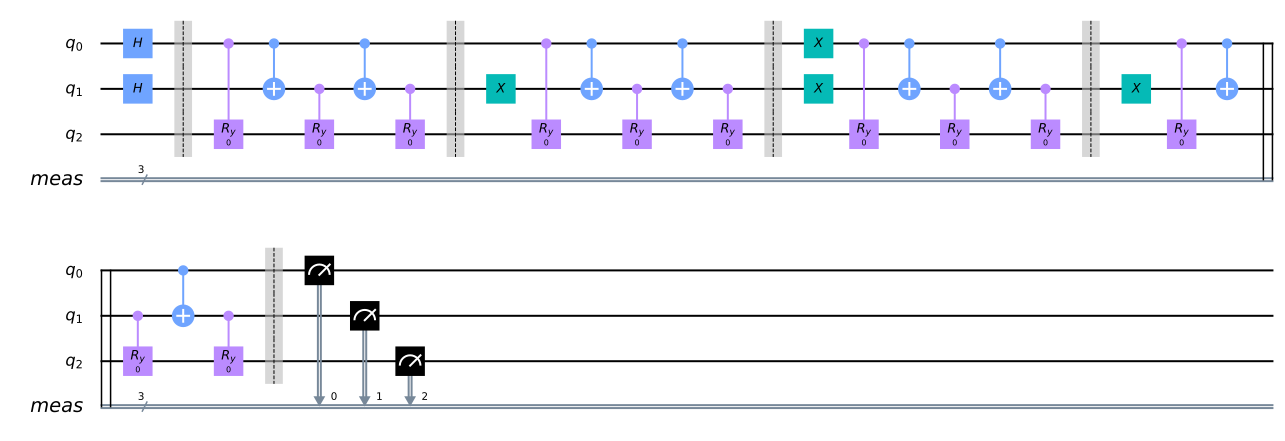

In [2]:
qc = QuantumCircuit(3)

theta=0 # all pixels black
#theta=pi/4 # all pixels half greyscale intensity
#theta=pi/2 # all pixels white
#theta=pi/8 # all pixels at 25% intensity

qc.h(0)
qc.h(1)

qc.barrier()
#Pixel 1

qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)

qc.barrier()
#Pixel 2

qc.x(1)

qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)

qc.barrier()

qc.x(1)
qc.x(0)
qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)


qc.barrier()

qc.x(1)

qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)

qc.measure_all()

qc.draw()

#### 3.1.1 Measurement and Image Retrieval


We can see from $(2.1)$ that all the terms associated with the state $\ket{1}$ in the color encoding part of the FRQI state will vanish because of the value of $\theta$ so we do expect to see only $4$ equiprobable states.


{'000': 1041, '011': 1021, '001': 1004, '010': 1030}


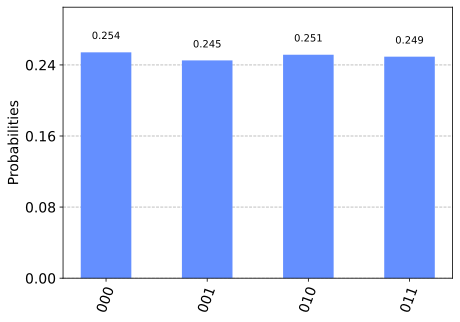

In [3]:
backend_sim = Aer.get_backend('aer_simulator')
job_sim = execute(qc, backend_sim,shots=4096)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)
plot_histogram(counts)

### 3.2 Example 2 : $\theta_{i}=\pi/2 \;, \; \forall i$ - all pixels at maximum intensity

The circuit is identical to the first defined, except for the value of $\theta$.

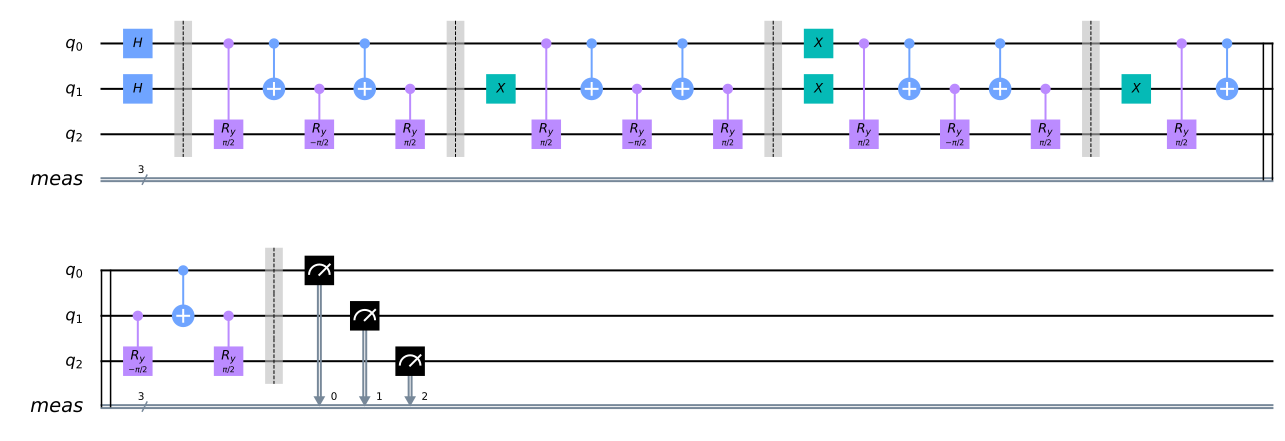

In [4]:
qc1 = QuantumCircuit(3)


theta=pi/2 # all pixels white


qc1.h(0)
qc1.h(1)

qc1.barrier()
#Pixel 1

qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)

qc1.barrier()
#Pixel 2

qc1.x(1)

qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)

qc1.barrier()

qc1.x(1)
qc1.x(0)
qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)


qc1.barrier()

qc1.x(1)

qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)

qc1.measure_all()

qc1.draw()

#### 3.2.1 Measurement and Image Retrieval
In this case we do expect to see the terms associated with the $\cos$ in the equation $(2.1)$ to vanish, and get 4 equiprobable states with a "1" prefix.

{'101': 1036, '110': 1037, '111': 1019, '100': 1004}


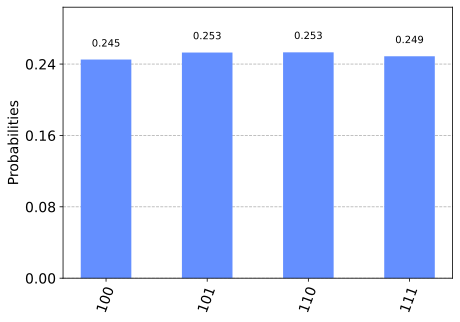

In [5]:
backend_sim = Aer.get_backend('aer_simulator')
job_sim = execute(qc1, backend_sim,shots=4096)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc1)
print(counts)
plot_histogram(counts)

### 3.3 Example  3 : $\theta_{i}=\pi/4 \;, \; \forall i$ - all pixels at $50\%$ intensity

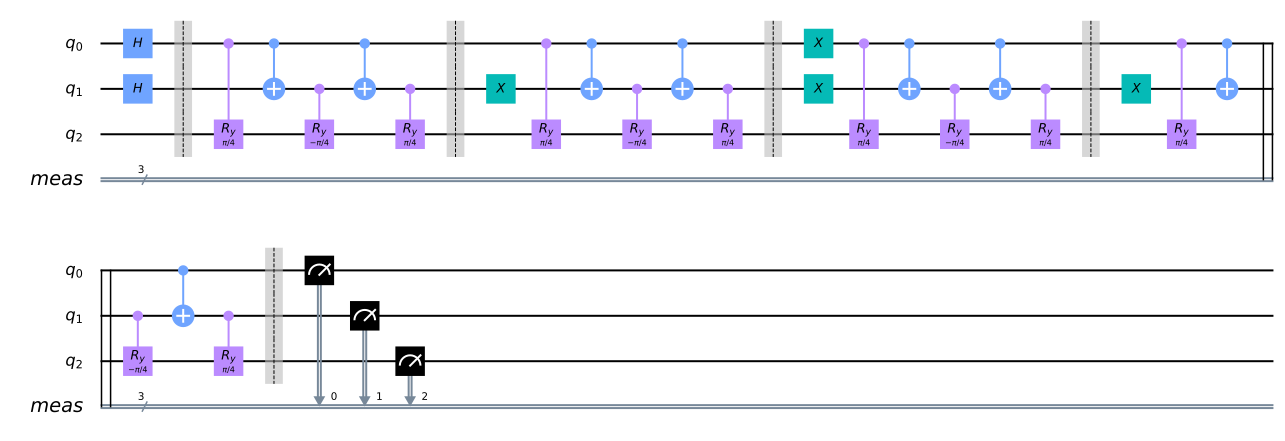

In [6]:
qc2 = qk.QuantumCircuit(3)


theta=pi/4 # all pixels white


qc2.h(0)
qc2.h(1)

qc2.barrier()
#Pixel 1

qc2.cry(theta,0,2)
qc2.cx(0,1)
qc2.cry(-theta,1,2)
qc2.cx(0,1)
qc2.cry(theta,1,2)

qc2.barrier()
#Pixel 2

qc2.x(1)

qc2.cry(theta,0,2)
qc2.cx(0,1)
qc2.cry(-theta,1,2)
qc2.cx(0,1)
qc2.cry(theta,1,2)

qc2.barrier()

qc2.x(1)
qc2.x(0)
qc2.cry(theta,0,2)
qc2.cx(0,1)
qc2.cry(-theta,1,2)
qc2.cx(0,1)
qc2.cry(theta,1,2)


qc2.barrier()

qc2.x(1)

qc2.cry(theta,0,2)
qc2.cx(0,1)
qc2.cry(-theta,1,2)
qc2.cx(0,1)
qc2.cry(theta,1,2)

qc2.measure_all()

qc2.draw()

#### 3.3.1 Measurement and Image Retrieval
In this case we do expect to get all the 8 equiprobable states.

{'011': 532, '000': 461, '111': 482, '101': 524, '110': 520, '100': 505, '001': 524, '010': 548}


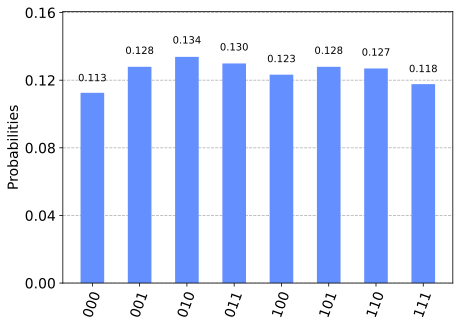

In [7]:
backend_sim = Aer.get_backend('aer_simulator')
job_sim = execute(qc2, backend_sim,shots=4096)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc2)
print(counts)
plot_histogram(counts)

## 4. Circuit Analysis and Running on a Real Device
As the only difference between the circuits is the rotation angle $\theta$, we can check the depth, and number of gates needed for this class of circuits (i.e. 2x2 images).

### 4.1 Circuit Analysis

Let's use our circuit with $\theta_{i}=\pi/2 \;, \; \forall i$ as exemple (maximum intensity for all pixels).

In [8]:
print("Depth : ",qc1.depth())
print("Operations: ", qc1.count_ops())

Depth :  23
Operations:  OrderedDict([('cry', 12), ('cx', 8), ('barrier', 5), ('x', 4), ('measure', 3), ('h', 2)])


This does not look too complex but if we want to see how this circuit can be unrolled by the transpiler, it gets a bit more complicated.

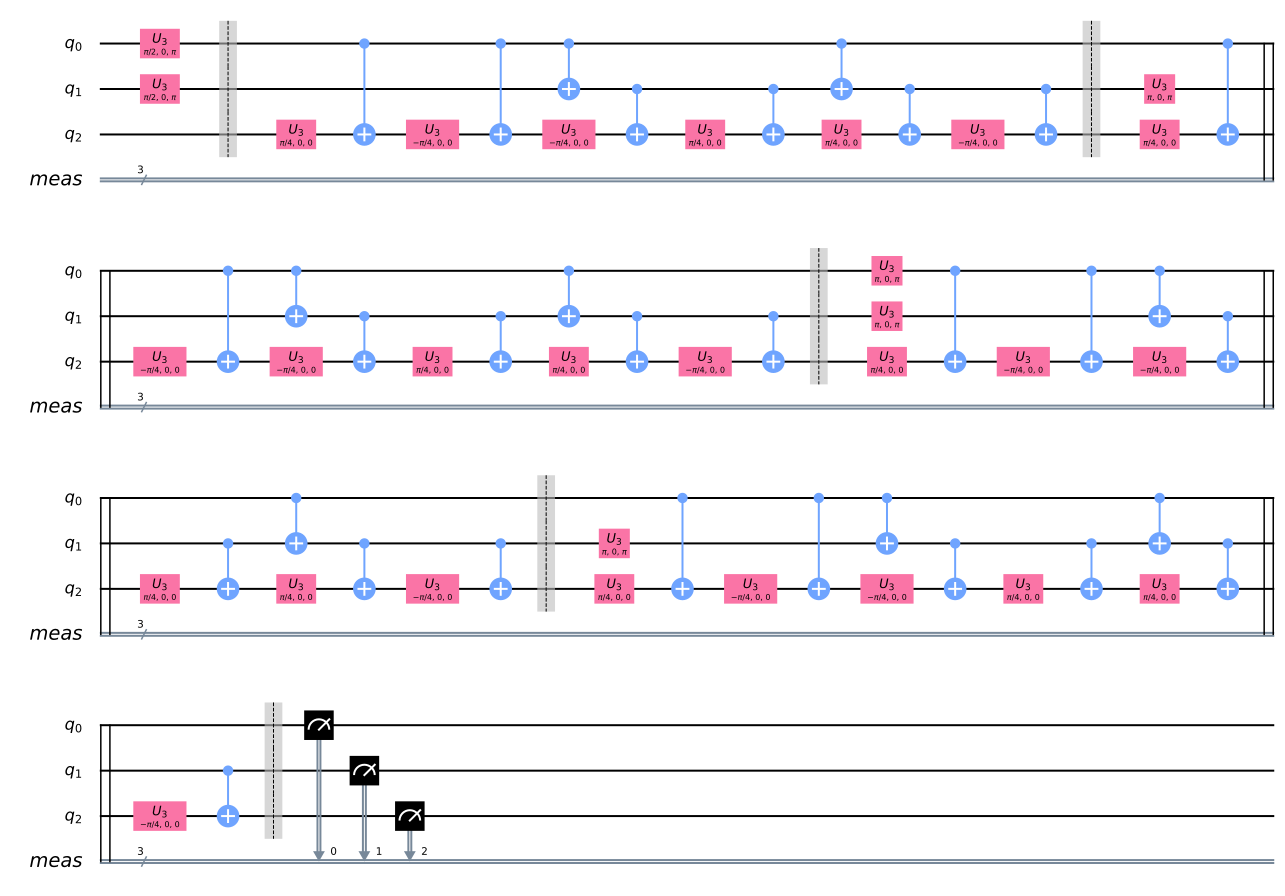

In [9]:
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qc1)
new_circ.draw()

In [10]:
print("Depth : ",new_circ.depth())
print("Operations: ", new_circ.count_ops())

Depth :  50
Operations:  OrderedDict([('cx', 32), ('u3', 30), ('barrier', 5), ('measure', 3)])


The depth, for example, doubled in size! We can get closer to what would actually be run on a real device by feeding the transpiler with a device coupling map (for instance, Vigo). We will also use optimization level 3.

In [11]:
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()
# The device coupling map is needed for transpiling to correct
# CNOT gates before simulation
coupling_map = device_backend.configuration().coupling_map
optimized_3 = transpile(qc1, backend=device_backend, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('cx', 55), ('u3', 29), ('u2', 16), ('barrier', 5), ('measure', 3)])
depth =  80


### 4.2 Run on a Real Device

We are now ready to run on a real device and will use the device Vigo for this experience.

{'011': 388, '000': 260, '111': 1225, '101': 667, '110': 458, '100': 516, '001': 223, '010': 359}


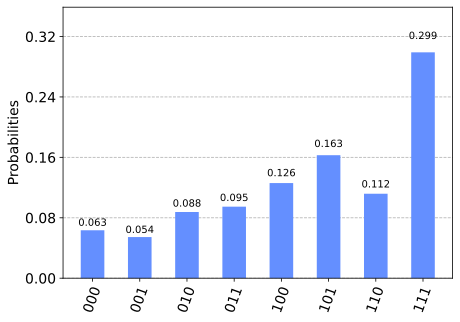

In [12]:
my_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_real = my_provider.get_backend('ibmq_vigo')
job_real = execute(qc1, backend_real,shots=4096)
result_real = job_real.result()
counts = result_real.get_counts(qc1)
print(counts)
plot_histogram(counts)

As we can see the result is not really what we were expecting due to errors in the computation. We can compare this to the results on the error-free simulator:

{'101': 990, '110': 1023, '111': 1022, '100': 1061}


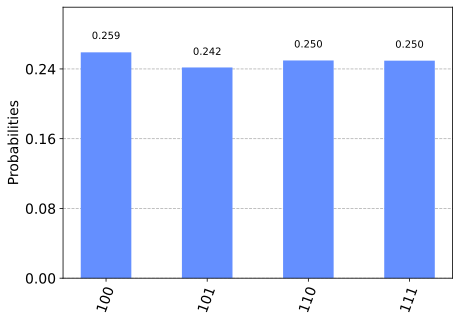

In [14]:
backend_sim = Aer.get_backend('aer_simulator')
job_sim = execute(qc1, backend_sim,shots=4096)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc1)
print(counts)
plot_histogram(counts)

## 5. Compression

As the images we would like to encode are growing in size and given the depth of the circuits we will have to run, it is quite obvious that whatever we can do in order to reduce the complexity of the circuit (depth and number of $\text{CNOT}$ gates) will make a great difference.

Compression can be achieved by grouping pixels with the same intensity. What makes them distinct is the binary string used to encode the position, but they share the same angle for the associated controlled rotation. Let's consider for example the following image:

![](images/8x8_2col.png "8x8 2 colours image") 

The blue pixels are at positions are $\ket{0}, \ket{8}, \ket{16}, \ket{24}, \ket{32}, \ket{40}, \ket{48}$ and $\ket{56}$. 

Their respective binary representation and boolean expressions are:

\begin{array}{|c|c|c|}
\hline
\text{Position} & \text{Binary String} & \text{Boolean Expression} \\
\hline
\ket{0} &\ket{000000} & \overline{x_{5}}\overline{x_{4}}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\ket{8} &\ket{001000} & \overline{x_{5}}\overline{x_{4}}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\ket{16} &\ket{001000} & \overline{x_{5}}x_{4}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\ket{24} &\ket{011000} & \overline{x_{5}}x_{4}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\ket{32} &\ket{100000} & x_{5}\overline{x_{4}}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\ket{40} &\ket{101000} & x_{5}\overline{x_{4}}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\ket{48} &\ket{110000} & x_{5}x_{4}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\ket{56} &\ket{111000} & x_{5}x_{4}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}  \\
\hline
\end{array}

The boolean expression we would like to simplify/minimize is then :

$ \text{exp} = \overline{x_{5}}\overline{x_{4}}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+\overline{x_{5}}\overline{x_{4}}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+\overline{x_{5}}x_{4}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+\overline{x_{5}}x_{4}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+x_{5}\overline{x_{4}}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+x_{5}\overline{x_{4}}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+x_{5}x_{4}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+x_{5}x_{4}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}$

\begin{align*}
\text{exp}&=(\overline{x_{5}}+x_{5})(\overline{x_{4}}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}} +\overline{x_{4}}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+x_{4}\overline{x_{3}}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}+x_{4}x_{3}\overline{x_{2}}\overline{x_{1}}\overline{x_{0}})\\
       &=\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}(\overline{x_{4}}\overline{x_{3}}+\overline{x_{4}}x_{3}+x_{4}\overline{x_{3}}+x_{4}x_{3})\\
       &=\overline{x_{2}}\overline{x_{1}}\overline{x_{0}}
\end{align*}

We can then not only group the pixels under one conditional rotation, but we also see that the conditions for the controlled gate also have been reduced, which will result in a reduction of single gates needed for implementation. 

## 6. References 

[1] Le, P.Q., Dong, F. & Hirota, K. A flexible representation of quantum images for polynomial preparation, image compression, and processing operations. Quantum Inf Process 10, 63–84 (2011). https://doi.org/10.1007/s11128-010-0177-y 

[2] Le, Phuc Quang, Fayang Dong and Kaoru Hirota. “Flexible Representation of Quantum Images and Its Computational Complexity Analysis.” (2009). https://doi.org/10.14864/fss.25.0.185.0

In [15]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}